In [1]:
### 1. Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import snowflake.connector
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:


conn = snowflake.connector.connect(
    user='TFMGRUPO4',
    password='TFMgrupo4ucm01_01#',
    account='WYNIFVB-YE01854',
    warehouse='COMPUTE_WH',
    database='YAHOO_FINANCE',
    schema='MACHINE_LEARNING',
    role='ACCOUNTADMIN'
)

# Período de análisis
start_date = '2022-01-01'
end_date = '2024-12-31'


In [3]:
# Ejecutar la consulta SQL
cursor = conn.cursor()

query_ibex = f"""
    SELECT TICKER, STOCKOPEN, STOCKCLOSE, PAIS, DATE 
    FROM INDEX_TOTALES
    WHERE TICKER = '^IBEX'
      AND DATE BETWEEN '{start_date}' AND '{end_date}'
    ORDER BY DATE
"""

cursor.execute(query_ibex)
column_names = [desc[0] for desc in cursor.description]
df_ibex = pd.DataFrame(cursor.fetchall(), columns=column_names)

# Convertir DATE a tipo datetime
df_ibex['DATE'] = pd.to_datetime(df_ibex['DATE'])

# Renombrar la columna de cierre a "IBEX"
df_ibex.rename(columns={'STOCKCLOSE': 'IBEX'}, inplace=True)

# Mostrar el DataFrame sin mover DATE al índice
df_ibex.head()



,TICKER,STOCKOPEN,IBEX,PAIS,DATE
0,^IBEX,8729.7001950,8761.2001950,España,2022-01-03
1,^IBEX,8821.5996090,8795.7998050,España,2022-01-04
2,^IBEX,8799.5996090,8790.7998050,España,2022-01-05
3,^IBEX,8664.5996090,8789.9003910,España,2022-01-06
4,^IBEX,8781.9003910,8751.7998050,España,2022-01-07


In [4]:
df_ibex.columns

Index(['TICKER', 'STOCKOPEN', 'IBEX', 'PAIS', 'DATE'], dtype='object')

In [5]:
df_ibex.dtypes

TICKER               object
STOCKOPEN            object
IBEX                 object
PAIS                 object
DATE         datetime64[ns]
dtype: object

In [6]:
df_ibex['IBEX'] = df_ibex['IBEX'].astype(float)

In [7]:
df_ibex.dtypes

TICKER               object
STOCKOPEN            object
IBEX                float64
PAIS                 object
DATE         datetime64[ns]
dtype: object

In [8]:
# Definir el ticker a analizar
ticker_activo = 'BBVA.MC'

# Consulta a Snowflake
query_activo = f"""
    SELECT FECHA, CLOSE
    FROM TICKERS_INDEX
    WHERE TICKER = '{ticker_activo}'
      AND FECHA BETWEEN '{start_date}' AND '{end_date}'
    ORDER BY FECHA
"""
cursor.execute(query_activo)

# Crear DataFrame
df_activo = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_activo['FECHA'] = pd.to_datetime(df_activo['FECHA'])
df_activo.set_index('FECHA', inplace=True)

# Renombrar la columna 'CLOSE' con el nombre del ticker
df_activo.rename(columns={'CLOSE': ticker_activo}, inplace=True)

# Vista previa
df_activo.head()


,BBVA.MC
FECHA,
2022-01-03,5.260000229
2022-01-04,5.393000126
2022-01-05,5.380000114
2022-01-06,5.458000183
2022-01-07,5.586999893


In [9]:

cursor.close()
conn.close()


In [10]:
# Antes del join, establecer DATE como índice en df_ibex
df_ibex.set_index('DATE', inplace=True)


In [11]:

# Unir dataframes por la fecha (índice)
df = df_ibex[['IBEX']].join(df_activo, how='inner')

# Eliminar fechas con valores nulos
df.dropna(inplace=True)

# Vista previa
df.head()



,IBEX,BBVA.MC
DATE,,
2022-01-03,8761.200195,5.260000229
2022-01-04,8795.799805,5.393000126
2022-01-05,8790.799805,5.380000114
2022-01-06,8789.900391,5.458000183
2022-01-07,8751.799805,5.586999893


In [12]:
df['IBEX'] = df['IBEX'].astype(float)
df[ticker_activo] = df[ticker_activo].astype(float)

In [13]:

### 4. Calcular retornos diarios
returns = df.pct_change().dropna()


In [14]:

### 5. Tasa libre de riesgo
rf_annual = 0.03
rf_daily = (1 + rf_annual)**(1/252) - 1


In [15]:
### 6. Modelo CAPM: E(ri) = rf + β * (E(rm) - rf)

# Calcular excesos de retorno para la regresión
exceso_mercado = returns["IBEX"] - rf_daily  # E(rm) - rf
exceso_activo = returns[ticker_activo] - rf_daily  # ri - rf

# Regresión: (ri - rf) = α + β * (rm - rf)
X = exceso_mercado.values.reshape(-1,1)
y = exceso_activo.values

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

beta = model.coef_[0]
alpha = model.intercept_  # Alpha de Jensen
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)

# Calcular retornos esperados según CAPM
retorno_esperado_mercado = returns["IBEX"].mean()  # E(rm)
retorno_esperado_activo = rf_daily + beta * (retorno_esperado_mercado - rf_daily)  # E(ri)

In [16]:
### 6. Modelo CAPM: E(ri) = rf + β * (E(rm) - rf)

# Calcular excesos de retorno para la regresión
exceso_mercado = returns["IBEX"] - rf_daily  # E(rm) - rf
exceso_activo = returns[ticker_activo] - rf_daily  # ri - rf

# Regresión: (ri - rf) = α + β * (rm - rf)
X = exceso_mercado.values.reshape(-1,1)
y = exceso_activo.values

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

beta = model.coef_[0]
alpha = model.intercept_  # Alpha de Jensen
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)

# Calcular retornos esperados según CAPM
retorno_esperado_mercado = returns["IBEX"].mean()  # E(rm)
retorno_esperado_activo = rf_daily + beta * (retorno_esperado_mercado - rf_daily)  # E(ri)

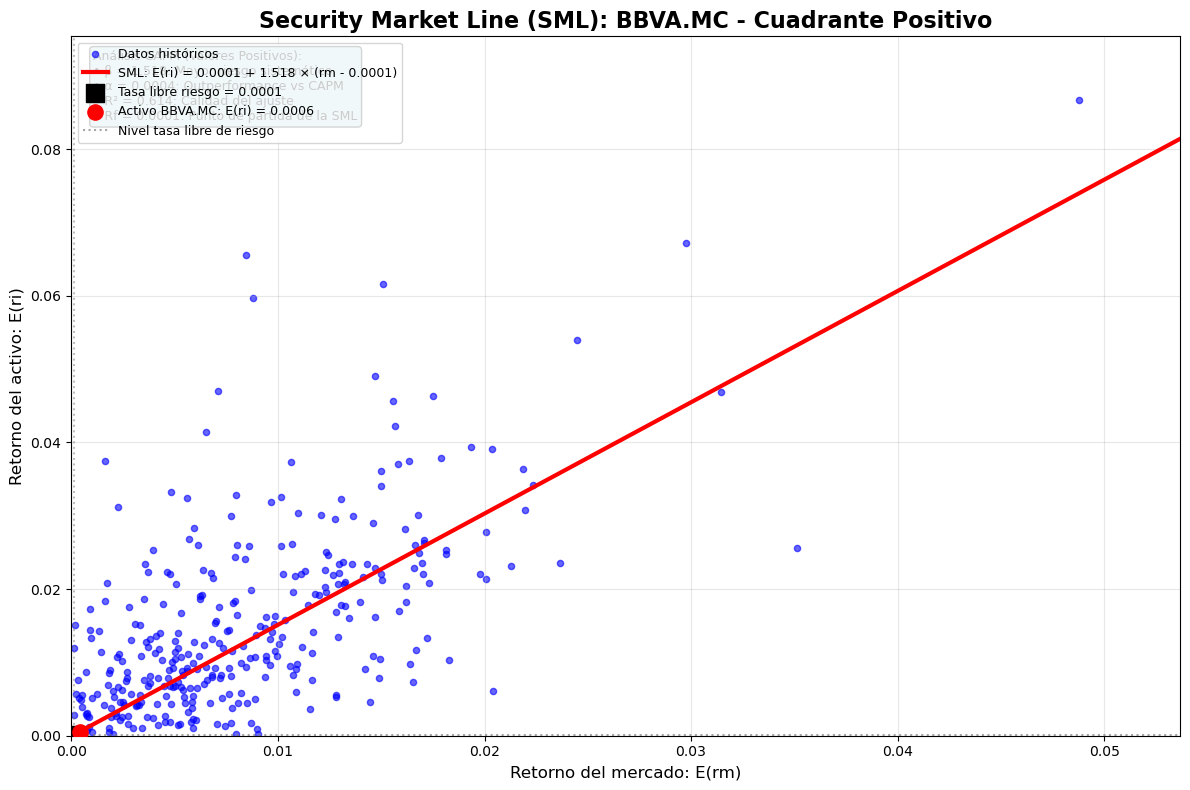

In [20]:
### 8. Gráfico CAPM Tradicional (Security Market Line) - Solo valores positivos
plt.figure(figsize=(12, 8))

# Convertir excesos a retornos absolutos para mostrar solo valores positivos
retorno_mercado_abs = exceso_mercado + rf_daily
retorno_activo_abs = exceso_activo + rf_daily

# Filtrar solo valores positivos
mask_positivos = (retorno_mercado_abs > 0) & (retorno_activo_abs > 0)
retorno_mercado_pos = retorno_mercado_abs[mask_positivos]
retorno_activo_pos = retorno_activo_abs[mask_positivos]

# Datos de la regresión: solo valores positivos
plt.scatter(retorno_mercado_pos, retorno_activo_pos, alpha=0.6, color='blue', s=20, label="Datos históricos")

# Crear rango para la línea SML que inicie desde 0
x_range = np.linspace(0, retorno_mercado_pos.max() * 1.1, 100)

# Security Market Line (SML): E(ri) = rf + β * (rm - rf)
# Para valores absolutos: E(ri) = rf + β * (rm - rf)
y_sml = rf_daily + beta * (x_range - rf_daily)

# Línea SML principal (desde tasa libre de riesgo)
plt.plot(x_range, y_sml, color='red', linewidth=3, 
         label=f'SML: E(ri) = {rf_daily:.4f} + {beta:.3f} × (rm - {rf_daily:.4f})')

# Punto de la tasa libre de riesgo (cuando rm = rf, ri = rf)
plt.scatter([rf_daily], [rf_daily], color='black', s=150, marker='s', 
           label=f'Tasa libre riesgo = {rf_daily:.4f}', zorder=5)

# Punto del activo (con su retorno esperado)
retorno_activo_esperado = rf_daily + beta * (retorno_esperado_mercado - rf_daily)
plt.scatter([retorno_esperado_mercado], [retorno_activo_esperado], color='red', s=120, marker='o', 
           label=f'Activo {ticker_activo}: E(ri) = {retorno_activo_esperado:.4f}', zorder=5)

# Líneas de referencia solo en valores positivos
plt.axhline(rf_daily, color='gray', linestyle=':', alpha=0.7, label='Nivel tasa libre de riesgo')
plt.axvline(rf_daily, color='gray', linestyle=':', alpha=0.5)

# Configuración del gráfico - solo valores positivos
plt.xlim(0, retorno_mercado_pos.max() * 1.1)
plt.ylim(0, retorno_activo_pos.max() * 1.1)

plt.title(f'Security Market Line (SML): {ticker_activo} - Cuadrante Positivo', fontsize=16, fontweight='bold')
plt.xlabel('Retorno del mercado: E(rm)', fontsize=12)
plt.ylabel('Retorno del activo: E(ri)', fontsize=12)
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)

# Añadir interpretación en el gráfico
textstr = f'''Análisis CAPM (Valores Positivos):
• β = {beta:.3f}: {"Mayor" if beta > 1 else "Menor" if beta < 1 else "Igual"} riesgo sistemático
• α = {alpha:.4f}: {"Outperformance" if alpha > 0 else "Underperformance"} vs CAPM
• R² = {1 - mse/np.var(exceso_activo):.3f}: Calidad del ajuste
• Rf = {rf_daily:.4f}: Punto de partida de la SML'''

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [21]:
### 8b. Visualización CAPM Interactiva (Plotly) - Solo valores positivos

# Crear figura interactiva
fig = go.Figure()

# Convertir excesos a retornos absolutos para mostrar solo valores positivos
retorno_mercado_abs = exceso_mercado + rf_daily
retorno_activo_abs = exceso_activo + rf_daily

# Filtrar solo valores positivos
mask_positivos = (retorno_mercado_abs > 0) & (retorno_activo_abs > 0)
retorno_mercado_pos = retorno_mercado_abs[mask_positivos]
retorno_activo_pos = retorno_activo_abs[mask_positivos]

# Datos reales (scatter plot) - solo valores positivos
fig.add_trace(go.Scatter(
    x=retorno_mercado_pos,
    y=retorno_activo_pos,
    mode='markers',
    name='Datos históricos',
    marker=dict(
        color='blue',
        size=6,
        opacity=0.6
    ),
    hovertemplate='<b>Retorno IBEX</b>: %{x:.4f}<br><b>Retorno ' + ticker_activo + '</b>: %{y:.4f}<extra></extra>'
))

# Rango para las líneas - desde 0 hasta máximo valor positivo
x_range = np.linspace(0, retorno_mercado_pos.max() * 1.1, 100)

# Security Market Line (SML) - desde tasa libre de riesgo
y_sml = rf_daily + beta * (x_range - rf_daily)
fig.add_trace(go.Scatter(
    x=x_range,
    y=y_sml,
    mode='lines',
    name=f'SML: E(ri) = {rf_daily:.4f} + {beta:.3f} × (rm - {rf_daily:.4f})',
    line=dict(color='red', width=3),
    hovertemplate='<b>Security Market Line</b><br>Retorno mercado: %{x:.4f}<br>Retorno esperado: %{y:.4f}<extra></extra>'
))

# Punto de tasa libre de riesgo (cuando rm = rf, ri = rf)
fig.add_trace(go.Scatter(
    x=[rf_daily],
    y=[rf_daily],
    mode='markers',
    name=f'Tasa libre riesgo = {rf_daily:.4f}',
    marker=dict(
        color='black',
        size=15,
        symbol='square'
    ),
    hovertemplate='<b>Tasa Libre de Riesgo</b><br>Retorno: %{y:.4f}<extra></extra>'
))

# Punto del activo (con su retorno esperado)
retorno_activo_esperado = rf_daily + beta * (retorno_esperado_mercado - rf_daily)
fig.add_trace(go.Scatter(
    x=[retorno_esperado_mercado],
    y=[retorno_activo_esperado],
    mode='markers',
    name=f'Activo {ticker_activo}: E(ri) = {retorno_activo_esperado:.4f}',
    marker=dict(
        color='red',
        size=12,
        symbol='circle'
    ),
    hovertemplate='<b>Activo ' + ticker_activo + '</b><br>Retorno esperado: %{y:.4f}<extra></extra>'
))

# Líneas de referencia
fig.add_hline(y=rf_daily, line_dash="dot", line_color="gray", opacity=0.7)
fig.add_vline(x=rf_daily, line_dash="dot", line_color="gray", opacity=0.5)

# Configurar layout - solo valores positivos
fig.update_layout(
    title=dict(
        text=f"Security Market Line Interactiva: {ticker_activo} (Cuadrante Positivo)",
        x=0.5,
        font=dict(size=18)
    ),
    xaxis_title="Retorno del mercado: E(rm)",
    yaxis_title="Retorno del activo: E(ri)",
    hovermode='closest',
    width=900,
    height=600,
    template='plotly_white',
    xaxis=dict(range=[0, retorno_mercado_pos.max() * 1.1]),
    yaxis=dict(range=[0, retorno_activo_pos.max() * 1.1]),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.2)',
        borderwidth=1
    )
)

# Añadir información del modelo como anotación
fig.add_annotation(
    x=0.02, y=0.98,
    xref="paper", yref="paper",
    text=f"<b>Métricas CAPM:</b><br>" +
         f"Beta (β): {beta:.3f}<br>" +
         f"Alpha (α): {alpha:.4f}<br>" +
         f"R²: {1 - mse/np.var(exceso_activo):.3f}<br>" +
         f"Tasa libre riesgo: {rf_daily:.4f}<br>" +
         f"Punto de partida SML: ({rf_daily:.4f}, {rf_daily:.4f})",
    showarrow=False,
    align="left",
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="rgba(0,0,0,0.2)",
    borderwidth=1,
    font=dict(size=10)
)

fig.show()

In [22]:
### 8c. Dashboard CAPM Simplificado

# Crear subgráficos
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        'Security Market Line (SML)', 
        'Distribución de Residuos del Modelo'
    )
)

# Convertir a retornos absolutos
retorno_mercado_abs = exceso_mercado + rf_daily
retorno_activo_abs = exceso_activo + rf_daily
mask_positivos = (retorno_mercado_abs > 0) & (retorno_activo_abs > 0)
retorno_mercado_pos = retorno_mercado_abs[mask_positivos]
retorno_activo_pos = retorno_activo_abs[mask_positivos]

# 1. Gráfico principal CAPM (izquierda)
fig.add_trace(
    go.Scatter(
        x=retorno_mercado_pos,
        y=retorno_activo_pos,
        mode='markers',
        name='Datos reales',
        marker=dict(color='blue', size=4, opacity=0.6),
        hovertemplate='IBEX: %{x:.4f}<br>' + ticker_activo + ': %{y:.4f}<extra></extra>'
    ),
    row=1, col=1
)

# Línea SML
x_range_dash = np.linspace(0, retorno_mercado_pos.max() * 1.1, 100)
y_sml_dash = rf_daily + beta * (x_range_dash - rf_daily)
fig.add_trace(
    go.Scatter(
        x=x_range_dash,
        y=y_sml_dash,
        mode='lines',
        name=f'SML: β={beta:.3f}',
        line=dict(color='red', width=2),
        showlegend=False
    ),
    row=1, col=1
)

# Punto de tasa libre de riesgo
fig.add_trace(
    go.Scatter(
        x=[rf_daily],
        y=[rf_daily],
        mode='markers',
        name='Tasa libre riesgo',
        marker=dict(color='black', size=10, symbol='square'),
        showlegend=False
    ),
    row=1, col=1
)

# 2. Histograma de residuos (derecha)
residuals = y - predictions
fig.add_trace(
    go.Histogram(
        x=residuals,
        name='Residuos',
        marker_color='lightblue',
        opacity=0.7,
        nbinsx=30,
        hovertemplate='Residuo: %{x:.4f}<br>Frecuencia: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# Actualizar layout
fig.update_layout(
    title_text=f"Dashboard CAPM: {ticker_activo} vs IBEX 35",
    title_x=0.5,
    height=500,
    width=1200,
    showlegend=True,
    template='plotly_white'
)

# Configurar ejes específicos
fig.update_xaxes(title_text="Retorno del mercado E(rm)", row=1, col=1, range=[0, retorno_mercado_pos.max() * 1.1])
fig.update_yaxes(title_text=f"Retorno del activo E(ri)", row=1, col=1, range=[0, retorno_activo_pos.max() * 1.1])

fig.update_xaxes(title_text="Residuos", row=1, col=2)
fig.update_yaxes(title_text="Frecuencia", row=1, col=2)

# Añadir líneas de referencia
fig.add_hline(y=rf_daily, line_dash="dot", line_color="gray", opacity=0.5, row=1, col=1)
fig.add_vline(x=rf_daily, line_dash="dot", line_color="gray", opacity=0.5, row=1, col=1)
fig.add_vline(x=0, line_dash="dot", line_color="gray", opacity=0.5, row=1, col=2)

fig.show()

In [23]:
### 9. Resultados del análisis CAPM

# Calcular métricas CAPM relevantes
r_squared = 1 - mse/np.var(exceso_activo)
sharpe_ratio_activo = (returns[ticker_activo].mean() - rf_daily) / returns[ticker_activo].std()
sharpe_ratio_mercado = (returns["IBEX"].mean() - rf_daily) / returns["IBEX"].std()
treynor_ratio = (returns[ticker_activo].mean() - rf_daily) / beta

# Crear DataFrame resumen
resultados = pd.DataFrame({
    'Métrica CAPM': [
        'Activo analizado',
        'Período de análisis',
        'Observaciones totales',
        'Tasa libre de riesgo (anual)',
        'Tasa libre de riesgo (diaria)',
        'Beta (β) - Riesgo sistemático',
        'Alpha (α) - Alpha de Jensen',
        'R² del modelo',
        'Error Cuadrado Medio',
        'Retorno esperado E(ri)',
        'Retorno esperado mercado E(rm)',
        'Ratio de Sharpe (activo)',
        'Ratio de Sharpe (mercado)',
        'Ratio de Treynor'
    ],
    'Valor': [
        ticker_activo,
        f"{start_date} a {end_date}",
        len(returns),
        f"{rf_annual:.1%}",
        f"{rf_daily:.6f}",
        f"{beta:.4f}",
        f"{alpha:.6f}",
        f"{r_squared:.4f}",
        f"{mse:.8f}",
        f"{retorno_esperado_activo:.6f}",
        f"{retorno_esperado_mercado:.6f}",
        f"{sharpe_ratio_activo:.4f}",
        f"{sharpe_ratio_mercado:.4f}",
        f"{treynor_ratio:.6f}"
    ]
})

resultados

,Métrica CAPM,Valor
0,Activo analizado,BBVA.MC
1,Período de análisis,2022-01-01 a 2024-12-31
2,Observaciones totales,766
3,Tasa libre de riesgo (anual),3.0%
4,Tasa libre de riesgo (diaria),0.000117
5,Beta (β) - Riesgo sistemático,1.5177
6,Alpha (α) - Alpha de Jensen,0.000381
7,R² del modelo,0.6144
8,Error Cuadrado Medio,0.00014276
9,Retorno esperado E(ri),0.000560


In [24]:
### 10. Interpretación financiera CAPM

# Interpretaciones del análisis CAPM
interpretacion = pd.DataFrame({
    'Aspecto': [
        'Riesgo sistemático (Beta)',
        'Alpha de Jensen',
        'Calidad del modelo (R²)',
        'Eficiencia de riesgo (Sharpe)',
        'Eficiencia de riesgo sistemático (Treynor)',
        'Valoración del activo',
        'Recomendación de inversión'
    ],
    'Interpretación': [
        f"β = {beta:.3f}: El activo tiene {abs((beta-1)*100):.1f}% {'más' if beta > 1 else 'menos'} riesgo sistemático que el mercado",
        f"α = {alpha:.4f}: {'Alpha positivo indica outperformance' if alpha > 0 else 'Alpha negativo indica underperformance'} vs CAPM",
        f"R² = {r_squared:.3f}: El {r_squared*100:.1f}% de la variabilidad se explica por el mercado",
        f"Sharpe = {sharpe_ratio_activo:.3f} vs mercado {sharpe_ratio_mercado:.3f}: {'Mejor' if sharpe_ratio_activo > sharpe_ratio_mercado else 'Peor'} eficiencia riesgo-retorno",
        f"Treynor = {treynor_ratio:.4f}: Retorno por unidad de riesgo sistemático",
        "Activo está " + ("sobrevalorado" if alpha > 0 else "infravalorado" if alpha < 0 else "correctamente valorado") + " según CAPM",
        f"{'Recomendado' if alpha > 0 and sharpe_ratio_activo > sharpe_ratio_mercado else 'No recomendado'} para carteras diversificadas"
    ]
})

interpretacion

,Aspecto,Interpretación
0,Riesgo sistemático (Beta),β = 1.518: El activo tiene 51.8% más riesgo si...
1,Alpha de Jensen,α = 0.0004: Alpha positivo indica outperforman...
2,Calidad del modelo (R²),R² = 0.614: El 61.4% de la variabilidad se exp...
3,Eficiencia de riesgo (Sharpe),Sharpe = 0.043 vs mercado 0.029: Mejor eficien...
4,Eficiencia de riesgo sistemático (Treynor),Treynor = 0.0005: Retorno por unidad de riesgo...
5,Valoración del activo,Activo está sobrevalorado según CAPM
6,Recomendación de inversión,Recomendado para carteras diversificadas
